Цей документ містить першу спробу зробити модель класифікатора текстів нейтральної та "упередженої" стилістики. По ходу будуть якісь коментарі, але основні висновки будуть в кінці.

Спочатку я завантажую скачані дані. На даний момент є така добірка:
* до класу "нейтральних текстів" я відніс новини з порталу Лівий Берег та науково-популярні статті з журналів Куншт та WAS
* до класу "упереджених" я відніс блоги з Лівого Берегу та замітки з сайту Нігіліст

Першого разу я зробив класифікацію самих текстів, у цьому ж документі міститься класифікація окремих абзаців з цих текстів. 

In [44]:
import joblib
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
import stanza
from spacy_stanza import StanzaLanguage
from tqdm.notebook import tqdm
import spacy
import matplotlib.pyplot as plt

snlp = stanza.Pipeline(lang="uk")
nlp = StanzaLanguage(snlp)

2020-05-01 23:28:00 INFO: Loading these models for language: uk (Ukrainian):
| Processor | Package |
-----------------------
| tokenize  | iu      |
| mwt       | iu      |
| pos       | iu      |
| lemma     | iu      |
| depparse  | iu      |

2020-05-01 23:28:00 INFO: Use device: cpu
2020-05-01 23:28:00 INFO: Loading: tokenize
2020-05-01 23:28:00 INFO: Loading: mwt
2020-05-01 23:28:00 INFO: Loading: pos
2020-05-01 23:28:00 INFO: Loading: lemma
2020-05-01 23:28:00 INFO: Loading: depparse
2020-05-01 23:28:01 INFO: Done loading processors!


In [2]:
import matplotlib

matplotlib.rcParams['figure.figsize'] = (20, 10)
matplotlib.rcParams['figure.dpi'] = 100

In [3]:
def text_prettifier(texts, site):
    prettified = []
    for paragraphs in texts:
        if site == 'kunsht':
            pretty_text = ' '.join([p.replace('\xa0', ' ') for p in paragraphs[:-8] if len(p)>1])
        elif (site == 'nihilist' or site == 'was') and len(paragraphs) > 3:
            pretty_text = ' '.join([p.replace('\xa0', ' ') for p in paragraphs[:-1] if len(p.split(' '))>3])
        elif site == 'lb' and len(paragraphs) > 3:
            pretty_text = ' '.join([p.replace('\xa0', ' ') for p in paragraphs if len(p.split(' '))>3])
        else:
            print ('wring site keyword')
            return
        prettified.append(pretty_text)
    return prettified

def paragraph_prettifier(texts, site):
    prettified_paragraphs = []
    if site == 'kunsht':
        p_slice = slice(-8)
    elif site == 'was' or site == 'nihilist':
        p_slice =slice(-1)
    elif site in ('lb_blogs', 'lb_news'):
        p_slice = slice(None,None)
    for paragraphs in texts:
        for p in paragraphs[p_slice]:
            if len(p) > 3 and len(p.split(' '))>5 and not p.isspace(): 
                    prettified_paragraphs.append(p)
    return prettified_paragraphs

In [4]:
raw_data = {
    'kunsht': joblib.load('kunsht.joblib'), 
    'nihilist': joblib.load('nihilist.joblib'), 
    'lb_blogs': joblib.load('lb_100_pages.joblib'), 
    'was': joblib.load('was_texts.joblib'),
    'lb_news': joblib.load('lb_politycs_news_for_100_pages.joblib'),
}

In [5]:
paragraphs_data = {}

for site, data in raw_data.items():
    print('Number of texts before processing')
    paragraphs_data[site] = paragraph_prettifier(data, site)
    print(site, len(data), len(paragraphs_data[site]))

Number of texts before processing
kunsht 177 4915
Number of texts before processing
nihilist 241 4146
Number of texts before processing
lb_blogs 1786 28809
Number of texts before processing
was 448 10257
Number of texts before processing
lb_news 2195 17492


In [5]:
spacy_docs = {}

Для першої спроби я взяв лише 1500 параграфів з кожної категорії, тому що обробка їх з допомогою мовної моделі займає десь годину. З параграфів я подіставав деякі фічі, які пробував передавати векторайзеру по черзі, дивлячись, чи змінюється метрика. Такі фічі: 
* сирий текст
* леми
* просто POS теги замість слів
* текст без стоп-слів
* сирий текст, але усі PROPN замінені на тег PROPN. Це була така апроксимація того, як я замінив би у тексті іменовані сутності, просто ще не дійшов до NER моделі.

In [6]:
#spacy_docs = {}

for site, data in paragraphs_data.items():
    spacy_docs[site] = list(tqdm(nlp.pipe(data[:1500])))

In [6]:
def extract_features_with_spacy(doc):
    lemmas = []
    text_without_stops = []
    poses = []
    
    doc_tokens = [w.text for w in doc]
    for word in doc:
        if word not in spacy.lang.uk.stop_words.STOP_WORDS:
            text_without_stops.append(word.text)
        lemmas.append(word.lemma_)
        poses.append(word.pos_)
    text_without_propn = [
        word if pos != 'PROPN' else pos
        for (word, pos)
        in zip(doc_tokens, poses)
    ]
    return text_without_stops, lemmas, poses, text_without_propn

In [8]:
doc = spacy_docs['kunsht'][0]
doc

У землі ховається чимало нових відкриттів. Палеонтолог Вадим Яненко знає це як ніхто. Разом із колегою з Швейцарії Давідом Василяном він описав новий вид саламандр – Palaeoproteus miocenicus. Їхні рештки знайшли зокрема в селі Гриців Хмельницької області. Статтю про відкриття вчених опублікували в журналі Nature. Куншт поговорив з Вадимом про методи дослідження викопних решток і те, як опублікувати своє дослідження в одному з найвідоміших наукових журналів.

### 2 It's Modeling Time!

In [9]:
site_to_label = {
    'kunsht': ('neutral', 'val'),
    'nihilist': ('subjective', 'val'), 
    'lb_blogs': ('subjective', 'train'), 
    'was': ('neutral', 'val'),
    'lb_news': ('neutral', 'train'),
}

In [10]:
total_texts = []
for site, (label, sample) in site_to_label.items():
    for doc in spacy_docs[site]:
        text_without_stops, lemmas, poses, text_without_propn = extract_features_with_spacy(doc)
        text = doc.text
        total_texts += [
            (site, 
             label, 
             sample, 
             text, 
             ' '.join(text_without_stops), 
             ' '.join(lemmas), 
             ' '.join(poses), 
             ' '.join(text_without_propn)) 
        ]
    print(f'added {site}')

added kunsht
added nihilist
added lb_blogs
added was
added lb_news


In [11]:
df = pd.DataFrame(total_texts, columns=['site', 'label', 'sample', 'text', 'w_stops', 'lemmas', 'poses', 'text_without_propn'])
#val_df = pd.DataFrame(validate, columns=['text', 'label', 'w_stops', 'lemmas', 'poses'])

In [12]:
df.head()

,site,label,sample,text,w_stops,lemmas,poses,text_without_propn
0,kunsht,neutral,val,У землі ховається чимало нових відкриттів. Пал...,У землі ховається чимало нових відкриттів . Па...,у земля ховатися чимало новий відкриття . пале...,ADP NOUN VERB ADV ADJ NOUN PUNCT NOUN PROPN PR...,У землі ховається чимало нових відкриттів . Па...
1,kunsht,neutral,val,"Це була досить цікава історія. Я орнітолог, на...","Це була досить цікава історія . Я орнітолог , ...","це бути досить цікавий історія . я орнітолог ,...",PRON AUX ADV ADJ NOUN PUNCT PRON NOUN PUNCT VE...,"Це була досить цікава історія . Я орнітолог , ..."
2,kunsht,neutral,val,У 2017 році мій колега Олександр Ковальчук поз...,У 2017 році мій колега Олександр Ковальчук поз...,у 2017 рік мій колега Олександр Ковальчук позн...,ADP ADJ NOUN DET NOUN PROPN PROPN VERB PRON AD...,У 2017 році мій колега PROPN PROPN познайомив ...
3,kunsht,neutral,val,"Міоцен – найновіша епоха періоду неогену, друг...","Міоцен – найновіша епоха періоду неогену , дру...","міоцен – найновіший епоха період неогена , дру...",NOUN PUNCT ADJ NOUN NOUN NOUN PUNCT ADJ NOUN A...,"Міоцен – найновіша епоха періоду неогену , дру..."
4,kunsht,neutral,val,"Серед земноводних, що жили на території Україн...","Серед земноводних , що жили на території Украї...","серед земноводний , що жити на територія Украї...",ADP ADJ PUNCT SCONJ VERB ADP NOUN PROPN ADP NO...,"Серед земноводних , що жили на території PROPN..."


In [13]:
df.shape

(7500, 8)

У деяких текстах попливло кодування чогось, ну і Рудоманова треба прибрати) Це, звісно, не вся чистка тексів, що потрібна, треба буде список цей розширити.

In [14]:
df = df[(~df['text'].str.contains('Рудоманов')) |(~df['text'].str.contains('Ð'))].copy()
#val_df = val_df[~val_df['text'].str.contains('Ð')].copy()

In [74]:
df.to_csv('df_up_to_1500.csv')

In [7]:
df = pd.read_csv('df_up_to_1500.csv')

In [8]:
df['label'].value_counts()

neutral       4500
subjective    3000
Name: label, dtype: int64

Далі я спробував по одній колонці віддавати до векторайзера і дивитись, як сильно змінюється метрика. Дивився я на класіфікейшн репорт, а також окремо на ROC_AUC та F-0.5. Я думаю, що F-0.5 будет остаточною метрикою мого проекту, тому що нейтральність це річ неоднозначна, бо краще більш впевнено казати лише про окремі речі, тому precision має важити більше ніж recall.

Зараз я не сильно піклувався про гіперпараметри і конкретні моделі, тому що, мені здається, що це другорядна річ на даному етапі. Про це я сужу з того, що зараз більшою проблемою є постановка проблеми та датасет. Про це я також докладніше напишу в кінці. 

In [9]:
column_to_try = 'text_without_propn'

In [10]:
X_train_dev, X_test, y_train_dev, y_test = train_test_split(
    df[df['sample'] == 'train'][column_to_try],
    df[df['sample'] == 'train']['label'],
    random_state=42,
    test_size=0.10,
    stratify=df[df['sample'] == 'train']['label']
)

In [11]:
X_train, X_dev, y_train, y_dev = train_test_split(
    X_train_dev,
    y_train_dev,
    random_state=42,
    test_size=0.20,
    stratify=y_train_dev
)

In [12]:
X_val = df[df['sample']=='val'][column_to_try]
y_val = df[df['sample']=='val']['label']

In [13]:
print(X_train.shape, y_train.shape)

(2160,) (2160,)


In [14]:
y_train.value_counts()

subjective    1080
neutral       1080
Name: label, dtype: int64

In [15]:
print(classification_report(y_dev, ['subjective']*len(y_dev)))

              precision    recall  f1-score   support

     neutral       0.00      0.00      0.00       270
  subjective       0.50      1.00      0.67       270

    accuracy                           0.50       540
   macro avg       0.25      0.50      0.33       540
weighted avg       0.25      0.50      0.33       540



/home/yevhen/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [16]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, fbeta_score
from sklearn.pipeline import Pipeline

In [17]:
count_lr_clf = Pipeline([
    ('vect', CountVectorizer(ngram_range=(1,3))),
    ('scaler', StandardScaler(with_mean=False)),
    ('clf', LogisticRegression(
        random_state=42, 
        solver = 'sag',
        multi_class='multinomial',
        max_iter=6000,
    )),
])

In [18]:
tf_clf = Pipeline([
    ('vect', TfidfVectorizer(min_df=3,  max_features=None, 
            strip_accents='unicode', analyzer='word',
            ngram_range=(1, 3), use_idf=1,smooth_idf=1,sublinear_tf=1)),
    ('scaler', StandardScaler(with_mean=False)),
    ('clf', LogisticRegression(
        random_state=42, 
        solver = 'sag',
        multi_class='multinomial',
        max_iter=6000,
    )),
])

In [19]:
tf_rf = Pipeline([
    ('vect', TfidfVectorizer(min_df=3,  max_features=None, 
            strip_accents='unicode', analyzer='word',
            ngram_range=(1, 3), use_idf=1,smooth_idf=1,sublinear_tf=1)),
    ('scaler', StandardScaler(with_mean=False)),
    ('clf', RandomForestClassifier(
        random_state=42, 
        max_depth=20,   
        n_estimators=4000,
        n_jobs=-1
    )),
])

In [20]:
X_train

4123    Міжнародний досвід засвідчує , що боргові криз...
6523    Серед людей , яких PROPN видала 16 квітня в ра...
3565    - Представляти інтереси PROPN у закордонних юр...
7191    За його словами , PROPN " кожен день чекає ост...
3507             1 . Податковий напрям : земля як тягар .
                              ...                        
3142    Давайте одразу домовимося — не існує терміну «...
3833    Автором , проекту Закону PROPN « Про внесення ...
7251    PROPN PROPN , вважає слідство , знав про задум...
3783    Ми ще звернемося до цієї справи , адже в істор...
4185    У КК є відповідно норма про опір працівникові ...
Name: text_without_propn, Length: 2160, dtype: object

In [21]:
count_lr_clf.fit(X_train, y_train);

In [22]:
tf_clf.fit(X_train, y_train);

In [23]:
tf_rf.fit(X_train, y_train);

In [24]:
print('TRAIN PERFORMANCE')
for clf in (count_lr_clf, tf_clf, tf_rf):
    y_pred = clf.predict(X_dev)
    y_pred_proba = clf.predict_proba(X_dev)[:,1]
    f_beta_score = fbeta_score(y_dev, y_pred, beta=0.5, pos_label='subjective')
    print(clf['clf'])
    print(classification_report(y_dev, y_pred))
    print(f'ROC-AUC score = {roc_auc_score(y_dev, y_pred_proba)}')
    print(f'F-0.5 score = {f_beta_score}')
    print('='*80)


TRAIN PERFORMANCE
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=6000,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=42, solver='sag', tol=0.0001, verbose=0,
                   warm_start=False)
              precision    recall  f1-score   support

     neutral       0.88      0.90      0.89       270
  subjective       0.90      0.87      0.89       270

    accuracy                           0.89       540
   macro avg       0.89      0.89      0.89       540
weighted avg       0.89      0.89      0.89       540

ROC-AUC score = 0.9357064471879286
F-0.5 score = 0.8925869894099848
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=6000,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=42, s

In [25]:
for clf in (count_lr_clf, tf_clf, tf_rf):
    y_pred = clf.predict(X_val)
    y_pred_proba = clf.predict_proba(X_val)[:,1]
    f_beta_score = fbeta_score(y_val, y_pred, beta=0.5, pos_label='subjective')
    print(clf['clf'])
    print(classification_report(y_val, clf.predict(X_val)))
    print(f'ROC-AUC score = {roc_auc_score(y_val, y_pred_proba)}')
    print(f'F-0.5 score = {f_beta_score}')
    print('='*80)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=6000,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=42, solver='sag', tol=0.0001, verbose=0,
                   warm_start=False)
              precision    recall  f1-score   support

     neutral       0.71      0.35      0.47      3000
  subjective       0.35      0.72      0.47      1500

    accuracy                           0.47      4500
   macro avg       0.53      0.53      0.47      4500
weighted avg       0.59      0.47      0.47      4500

ROC-AUC score = 0.5763513333333333
F-0.5 score = 0.39425338036449153
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=6000,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=42, solver='sag', tol=

In [26]:
for clf in (tf_rf,):
    y_pred = clf.predict(X_val)
    y_pred_proba = clf.predict_proba(X_val)[:,1]
    f_beta_score = fbeta_score(y_val, y_pred, beta=0.5, pos_label='subjective')
    print(clf['clf'])
    print(classification_report(y_val, clf.predict(X_val)))
    print(f'ROC-AUC score = {roc_auc_score(y_val, y_pred_proba)}')
    print(f'F-0.5 score = {f_beta_score}')
    print('='*80)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=20, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=4000,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
              precision    recall  f1-score   support

     neutral       0.73      0.41      0.52      3000
  subjective       0.37      0.71      0.49      1500

    accuracy                           0.51      4500
   macro avg       0.55      0.56      0.51      4500
weighted avg       0.61      0.51      0.51      4500

ROC-AUC score = 0.5974876666666666
F-0.5 score = 0.41212215643502653


In [27]:
vect = Pipeline([
    ('vect', TfidfVectorizer(min_df=3,  max_features=None, 
            strip_accents='unicode', analyzer='word',
            ngram_range=(1, 3), use_idf=1,smooth_idf=1,sublinear_tf=1)),
    ('scaler', StandardScaler(with_mean=False)),
])

In [28]:
X_train_feats = vect.fit_transform(X_train)
X_dev_feats = vect.transform(X_dev)
X_test_feats = vect.transform(X_val)

In [29]:
#vect['vect'].get_feature_names()

In [30]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(y_dev)

LabelEncoder()

Зроблю ще спробу навчити XGBoost "з коробки"

In [39]:
import xgboost as xgb

def runXGB(train_X, train_y, test_X, test_y=None, test_X2=None, seed_val=17, child=1, colsample=0.3):
    param = {}
    param['objective'] = 'reg:linear'
    param['eta'] = 0.1
    param['max_depth'] = 6
    param['silent'] = 1
    param['eval_metric'] = "mae"
    param['min_child_weight'] = child
    param['subsample'] = 0.8
    param['colsample_bytree'] = colsample
    param['seed'] = seed_val
    num_rounds = 10000
    
    plst = list(param.items())
    xgtrain = xgb.DMatrix(train_X, label=train_y, feature_names=vect['vect'].get_feature_names())

    if test_y is not None:
        xgtest = xgb.DMatrix(test_X, label=test_y, feature_names=vect['vect'].get_feature_names())
        watchlist = [ (xgtrain,'train'), (xgtest, 'test') ]
        model = xgb.train(plst, xgtrain, num_rounds, watchlist, early_stopping_rounds=50, verbose_eval=10)
    else:
        xgtest = xgb.DMatrix(test_X)
        model = xgb.train(plst, xgtrain, num_rounds)

    pred_test_y = model.predict(xgtest, ntree_limit = model.best_ntree_limit)
    
    return pred_test_y, model

In [40]:
pred_dev_y, model_valid = runXGB(X_train_feats, le.transform(y_train), X_dev_feats, le.transform(y_dev))

[0]	train-mae:0.48592	test-mae:0.489444
Multiple eval metrics have been passed: 'test-mae' will be used for early stopping.

Will train until test-mae hasn't improved in 50 rounds.
[10]	train-mae:0.390412	test-mae:0.419332
[20]	train-mae:0.32628	test-mae:0.374981
[30]	train-mae:0.293978	test-mae:0.35266
[40]	train-mae:0.266164	test-mae:0.335671
[50]	train-mae:0.245299	test-mae:0.324611
[60]	train-mae:0.234273	test-mae:0.318775
[70]	train-mae:0.223831	test-mae:0.312584
[80]	train-mae:0.216368	test-mae:0.309373
[90]	train-mae:0.209129	test-mae:0.305227
[100]	train-mae:0.203015	test-mae:0.303515
[110]	train-mae:0.196025	test-mae:0.300634
[120]	train-mae:0.190241	test-mae:0.299153
[130]	train-mae:0.184711	test-mae:0.296434
[140]	train-mae:0.180356	test-mae:0.294733
[150]	train-mae:0.17569	test-mae:0.293963
[160]	train-mae:0.171941	test-mae:0.293461
[170]	train-mae:0.168322	test-mae:0.291906
[180]	train-mae:0.164422	test-mae:0.291007
[190]	train-mae:0.160711	test-mae:0.290878
[200]	train-ma

In [52]:
y_val_xgb = le.transform(y_val)
y_pred_vel_xgb = [1 if x > 0.8 else 0 for x in model_valid.predict(xgb.DMatrix(X_test_feats, feature_names=vect['vect'].get_feature_names()))]
y_pred_proba_xgb = model_valid.predict(xgb.DMatrix(X_test_feats, feature_names=vect['vect'].get_feature_names()))

print(classification_report(
    y_val_xgb, 
    y_pred_vel_xgb
))

f_beta_score_xgb = fbeta_score(
    y_val_xgb, 
    y_pred_vel_xgb, 
    beta=0.5, 
)
print(f'ROC-AUC score = {roc_auc_score(y_val_xgb, y_pred_proba_xgb)}')
print(f'F-0.5 score = {f_beta_score_xgb}')

              precision    recall  f1-score   support

           0       0.71      0.70      0.70      3000
           1       0.41      0.43      0.42      1500

    accuracy                           0.61      4500
   macro avg       0.56      0.56      0.56      4500
weighted avg       0.61      0.61      0.61      4500

ROC-AUC score = 0.5793415555555556
F-0.5 score = 0.41688244432936306


Класіфікейшн репорт на валідації трохи краще, але додаткові метрики не кращі за інші моделі. Можна вивести важливі фічі для буста.

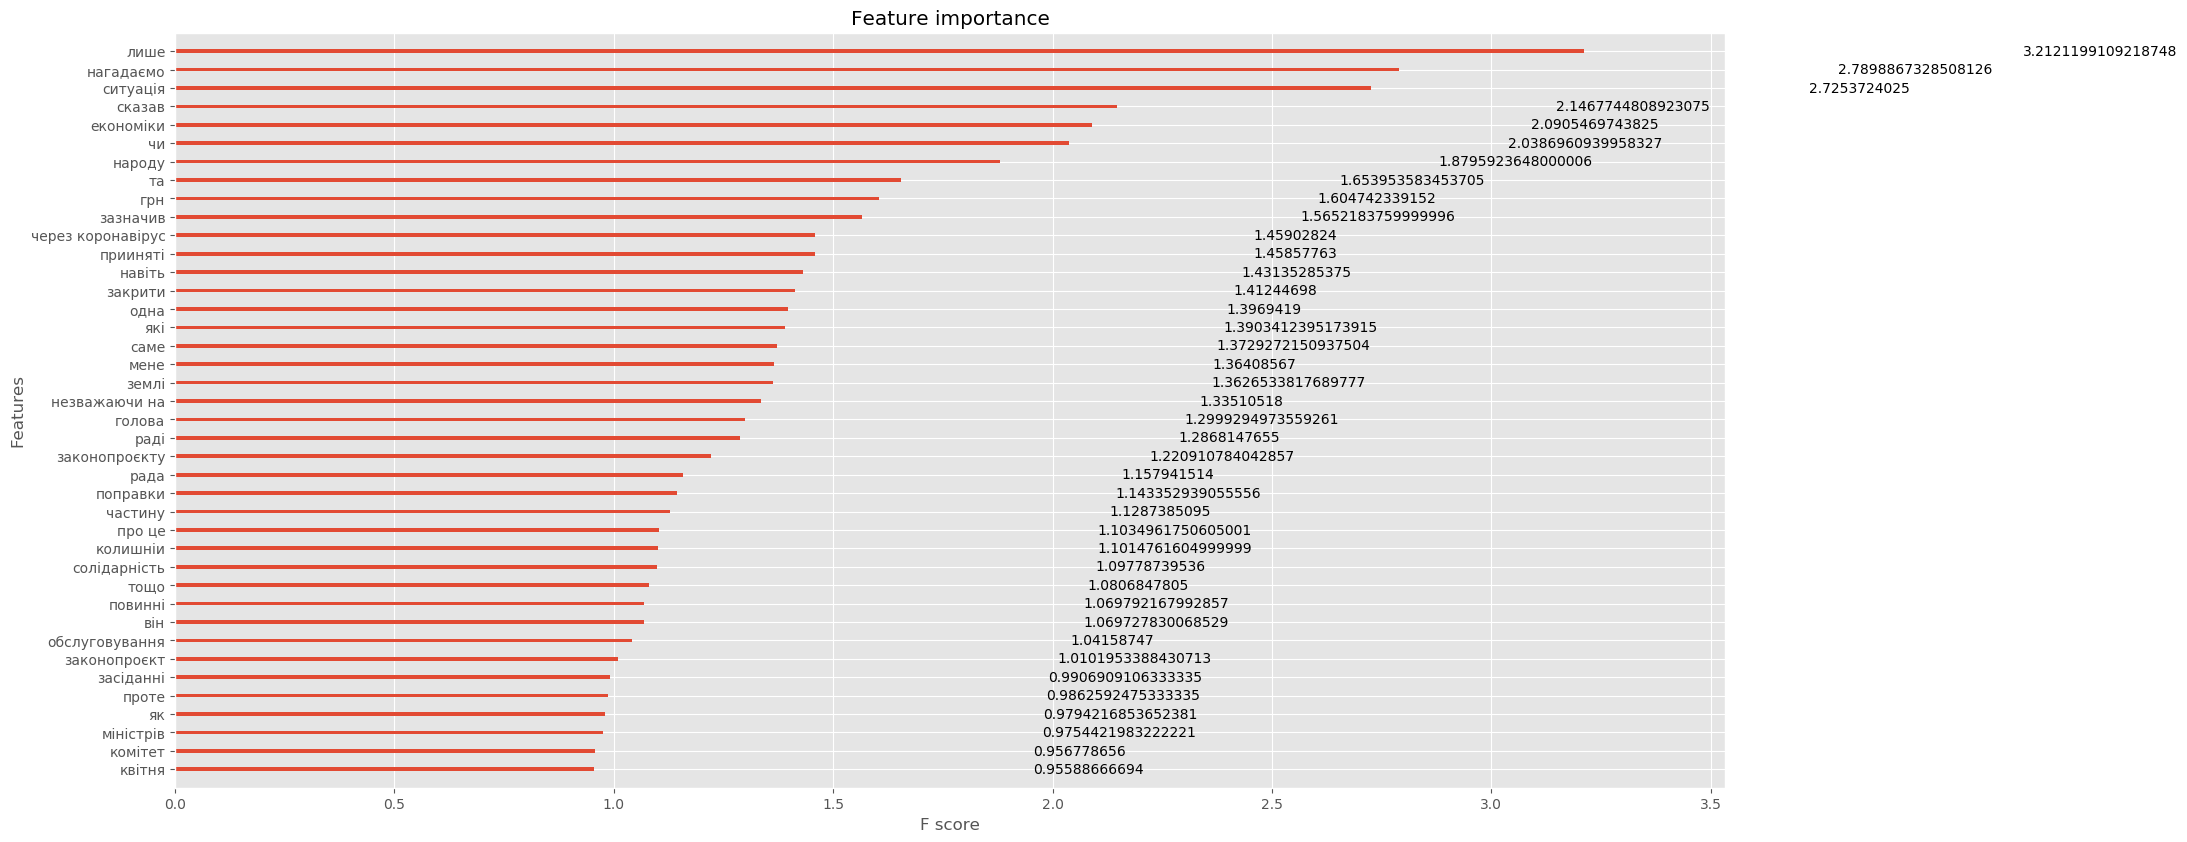

In [71]:
xgb.plot_importance(model_valid, importance_type='gain', max_num_features=40)

In [53]:
def get_top_n_words(corpus, n=None, ngrams=2):
    """
    List the top n words in a vocabulary according to occurrence in a text corpus.
    
    get_top_n_words(["I love Python", "Python is a language programming", "Hello world", "I love the world"]) -> 
    [('python', 2),
     ('world', 2),
     ('love', 2),
     ('hello', 1),
     ('is', 1),
     ('programming', 1),
     ('the', 1),
     ('language', 1)]
    """
    vec = CountVectorizer(
        ngram_range=(ngrams,ngrams),
    ).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]




for ngram in (2,3):
    print(f' NGRAM = {ngram}')
    for label in ('subjective', 'neutral'):
        print(f'LABEL IS {label}')
        label_revs = df[df['label']==label]['text'].values
        print(get_top_n_words(label_revs, 40, ngrams=ngram))
        print(' ')
        
print('='*80)
        
for ngram in (2,3):
    print(f' NGRAM = {ngram}')
    for label in ('subjective', 'neutral'):
        print(f'LABEL IS {label}')
        label_revs = df[df['label']==label]['text_without_propn'].values
        print(get_top_n_words(label_revs, 40, ngrams=ngram))
        print(' ')

 NGRAM = 2
LABEL IS subjective
[('те що', 154), ('тому що', 131), ('це не', 111), ('під час', 106), ('може бути', 82), ('не лише', 72), ('не може', 71), ('верховної ради', 70), ('про те', 66), ('відповідно до', 66), ('так само', 61), ('що не', 54), ('того щоб', 54), ('при цьому', 53), ('covid 19', 53), ('того що', 52), ('таким чином', 51), ('не має', 51), ('тих хто', 51), ('має бути', 49), ('ніколи не', 48), ('але не', 48), ('не буде', 45), ('вони не', 44), ('не було', 43), ('млрд грн', 43), ('до того', 42), ('2019 року', 42), ('не тільки', 42), ('для того', 41), ('ради україни', 41), ('що це', 40), ('все це', 39), ('зв язку', 39), ('2020 року', 38), ('що ми', 37), ('ми не', 37), ('до речі', 37), ('навіть якщо', 36), ('тому числі', 36)]
 
LABEL IS neutral
[('під час', 282), ('те що', 144), ('про це', 143), ('тому що', 114), ('про те', 72), ('за допомогою', 67), ('не було', 65), ('що це', 62), ('може бути', 60), ('2019 року', 58), ('на території', 57), ('до того', 56), ('не лише', 54), 

Перша спроба показала мені наступне:
* По-перше треба більш чітко сформулати задачу. Є специфічні види цієї ненейтральності і треба або обмежитись деякими типами, або намагатись більш таргетовано їх класифікувати. Тому що зараз відбувається просто "вгадай з якого сайту текст". 
* По-друге, ненейтральність зазвичай сконцентрована у певних виразах, конструкціях або словах, а не по всьому параграфу. Тому треба краще поставитись до формування датасету. Наступним кроком я зроблю ручне анотування певної кількості речень, а також пошукаю кращі джерела даних.
* Зараз моделі дуже страждають від специфічної лексики, що вживається в джерелах. Можливо можна якось позаміняти не тільки іменовані сутності, а й якісь дуже часті та характерні слова. Можливо треба краще сфокусуватись на загальних граматичних структурах, а не конкретній лексиці